# Ch.15 Trading strategies
This chapter is focused on algorithmic trading strategies and the backtesting of those strategies. An algorithmic trading strategy is implemented as software that applies rules to assets management, such as buying or selling those assets depending on some information or events. Once a trading strategy has been implemented it is tested on past data to assess its potential future performance. There exist several trading strategies, many well-known ones, such as the *moving average crossover* strategy seen in ch.8, and many other that are the secrets of asset management firms. 

In [1]:
import math
import numpy as np
import scipy.stats as scs
import scipy.optimize as sco
from scipy import interpolate
import pymc as pm
import statsmodels.api as sm
import pandas as pd
from pylab import plt, mpl
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
mpl.rcParams['font.family'] = 'serif'
%config InlineBackend.figure_format = 'svg'
print('Matplotlib version: {}'.format(mpl.__version__))
print('NumPy version: {}'.format(np.__version__))
print('Pandas version: {}'.format(pd.__version__))
print('PyMC version: {}'.format(pm.__version__))
print('Statsmodels version: {}'.format(sm.__version__))

Matplotlib version: 3.8.4
NumPy version: 1.26.4
Pandas version: 2.2.2
PyMC version: 5.20.1
Statsmodels version: 0.14.3


## Simple Moving Averages (SMAs)
This is one of the oldest and simple trading strategy (see [Brock et al. - Simple Technical Trading Rules and the Stochastic Properties of Stock Returns](https://www.jstor.org/stable/2328994))

In [4]:
raw = pd.read_csv('source/tr_eikon_eod_data.csv', index_col=0, parse_dates=True)
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2216 entries, 2010-01-01 to 2018-06-29
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL.O  2138 non-null   float64
 1   MSFT.O  2138 non-null   float64
 2   INTC.O  2138 non-null   float64
 3   AMZN.O  2138 non-null   float64
 4   GS.N    2138 non-null   float64
 5   SPY     2138 non-null   float64
 6   .SPX    2138 non-null   float64
 7   .VIX    2138 non-null   float64
 8   EUR=    2216 non-null   float64
 9   XAU=    2211 non-null   float64
 10  GDX     2138 non-null   float64
 11  GLD     2138 non-null   float64
dtypes: float64(12)
memory usage: 225.1 KB


We use the AAPL.O close stock prices

In [3]:
symbol = ['AAPL.O']
data = pd.DataFrame(raw[symbol]).dropna()
data.head(10)

,AAPL.O
Date,
2010-01-04,30.572827
2010-01-05,30.625684
2010-01-06,30.138541
2010-01-07,30.082827
2010-01-08,30.282827
2010-01-11,30.015684
2010-01-12,29.674256
2010-01-13,30.092827
2010-01-14,29.918542


### Simple moving averages
We set the size of two moving windows, that is the number of observations to be used to compute the moving average. Each data point in a moving average is calculated by taking the mean of a window size number of data points from the source time series and by moving one step forward till the end of it. 

In [4]:
SMA1 = 42
SMA2 = 252
data['SMA_42'] = data[symbol].rolling(SMA1).mean()
data['SMA_252'] = data[symbol].rolling(SMA2).mean()

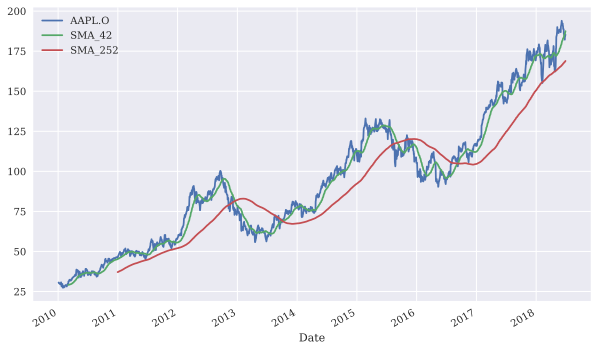

In [5]:
data.plot(figsize=(10, 6));

We reimplement the crossover trading strategy that we saw in ch.8. It is based on two SMAs, one short, e.g. 42 past trading days, and one long, e.g. 252 days.

* Go long (buy): set position to +1 when the shorter SMA is above the longer SMA.
* Go short (sell): set position to -1 when the shorter SMA is below the longer SMA

In this notebook we will also backtest the strategy.

In [9]:
data.dropna(inplace=True)

In [10]:
data['Position'] = np.where(data['SMA_42'] > data['SMA_252'], 1, -1)

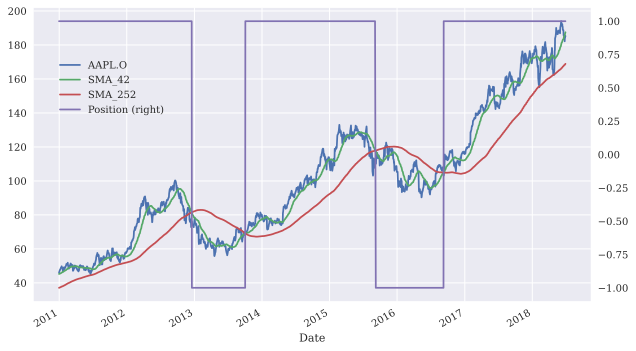

In [11]:
ax = data.plot(secondary_y='Position', figsize=(10, 6))
ax.get_legend().set_bbox_to_anchor((0.25, 0.85));

### Vectorized backtesting
Before using the SMA strategy on the AAPL.O stocks in production we better backtest it on past data at the very least. The backtest is performed against a do-nothing strategy where a long position is taken for the whole period. In order to evaluate the strategy we have to calculate the daily log-returns. 

In [12]:
data['Returns'] = np.log(data[symbol] / data[symbol].shift(1))

In [13]:
data['Strategy'] = data['Position'].shift(1) * data['Returns']

In [14]:
data.round(4).head()

,AAPL.O,SMA_42,SMA_252,Position,Returns,Strategy
Date,,,,,,
2010-12-31,46.0800,45.2810,37.1207,1,NaN,NaN
2011-01-03,47.0814,45.3497,37.1862,1,0.0215,0.0215
2011-01-04,47.3271,45.4126,37.2525,1,0.0052,0.0052
2011-01-05,47.7142,45.4661,37.3223,1,0.0081,0.0081
2011-01-06,47.6757,45.5226,37.3921,1,-0.0008,-0.0008


In [15]:
data.dropna(inplace=True)

We calculate the absolute performance for the strategy and the benchmark. We can see that our SMA strategy outperforms the go-long-and-do-nothing strategy. It must be taken into account that our simple strategy does not consider the transaction costs, the bid-ask spread and the taxes on the capital gains.

In [16]:
ret, strat = np.exp(data[['Returns', 'Strategy']].sum())
ret, strat

(4.017148114370324, 5.811299321180357)

In [31]:
outperformance = strat - ret
outperformance

1.7941512068100334

In [17]:
performance = ((strat - ret) / ret) * 100
performance

44.662311563567066

In [18]:
print('SMA strategy performance over the benchmark: {:.1f}%'.format(performance))

SMA strategy performance over the benchmark: 44.7%


Calculates the annualized volatility for the strategy and the benchmark

In [19]:
data[['Returns', 'Strategy']].std() * 252 ** 0.5

Returns     0.250571
Strategy    0.250407
dtype: float64

### Optimization
The lenght of the SMAs were arbitrary and might not give us the best strategy. One approach to improve is to perform a brute force optimization by backtesting the strategy changing the window's size of the SMA.

In [29]:
from itertools import product

In [28]:
sma1 = range(20, 61, 4)  
sma2 = range(180, 281, 10)  

We use the [itertools product()](https://docs.python.org/3/library/itertools.html#itertools.product) method to implement a nested for-loop to execute the same strategy as before changing the size of the short and long SMA windows. The results are written into a Pandas DataFrame. 

In [22]:
results = pd.DataFrame()
for SMA1, SMA2 in product(sma1, sma2):  
    data = pd.DataFrame(raw[symbol])
    data.dropna(inplace=True)
    data['Returns'] = np.log(data[symbol] / data[symbol].shift(1))
    data['SMA1'] = data[symbol].rolling(SMA1).mean()
    data['SMA2'] = data[symbol].rolling(SMA2).mean()
    data.dropna(inplace=True)
    data['Position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)
    data['Strategy'] = data['Position'].shift(1) * data['Returns']
    data.dropna(inplace=True)
    perf = np.exp(data[['Returns', 'Strategy']].sum())
    results = pd.concat((results, pd.DataFrame(
                {'SMA1': SMA1, 'SMA2': SMA2,
                 'MARKET': perf['Returns'],
                 'STRATEGY': perf['Strategy'],
                 'OUT': perf['Strategy'] - perf['Returns']},
                 index=[0])), ignore_index=True)  

In [23]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SMA1      121 non-null    int64  
 1   SMA2      121 non-null    int64  
 2   MARKET    121 non-null    float64
 3   STRATEGY  121 non-null    float64
 4   OUT       121 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 4.9 KB


We sort the results in order of outcome

In [24]:
results.sort_values('OUT', ascending=False).head(7)

,SMA1,SMA2,MARKET,STRATEGY,OUT
56,40,190,4.650342,7.175173,2.524831
39,32,240,4.045619,6.558690,2.513071
59,40,220,4.220272,6.544266,2.323994
46,36,200,4.074753,6.389627,2.314874
55,40,180,4.574979,6.857989,2.283010
70,44,220,4.220272,6.469843,2.249571
101,56,200,4.074753,6.319524,2.244772


Using short and long SMAs with window size 40 and 190 respectively provides a better outcome. The best window size depends on the data so this result will be likely different with other datasets. As a matter of fact the window size for short SMA are commonly set to 10 or 20 and to 50 or 200 for long SMA.

In [35]:
strat = results.sort_values('OUT', ascending=False).iloc[0]['STRATEGY']
ret = results.sort_values('OUT', ascending=False).iloc[0]['MARKET']
((strat - ret) / ret) * 100

54.2934405540579

## Random walk hypothesis
According to the *efficient market hypothesis* market prices reflect all the available information and the current price of an asset is like a random walk, in other words it is similar to a brownian motion, so that there is no need and no chance to develop a better strategy to figure out what will be its future price: it will be the same as today more or less a random component. In order to test this hypothesis we build five lagged time series from the original SPX sequence to see whether the lagged values can be used to predict the future value and which lagged value, contributes more to the prediction.

In [2]:
symbol = '.SPX'

In [5]:
data = pd.DataFrame(raw[symbol])

In [6]:
lags = 5
cols = []
for lag in range(1, lags + 1):
    col = 'lag_{}'.format(lag)
    data[col] = data[symbol].shift(lag)
    cols.append(col)

In [10]:
cols

['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5']

In [8]:
data.shape

(2216, 6)

In [7]:
data.head(7)

,.SPX,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,1132.99,NaN,NaN,NaN,NaN,NaN
2010-01-05,1136.52,1132.99,NaN,NaN,NaN,NaN
2010-01-06,1137.14,1136.52,1132.99,NaN,NaN,NaN
2010-01-07,1141.69,1137.14,1136.52,1132.99,NaN,NaN
2010-01-08,1144.98,1141.69,1137.14,1136.52,1132.99,NaN
2010-01-11,1146.98,1144.98,1141.69,1137.14,1136.52,1132.99


We remove the rows without a numerical value

In [9]:
data.dropna(inplace=True)
data.shape

(1760, 6)

In [11]:
data.head()

,.SPX,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,
2010-01-11,1146.98,1144.98,1141.69,1137.14,1136.52,1132.99
2010-01-12,1136.22,1146.98,1144.98,1141.69,1137.14,1136.52
2010-01-13,1145.68,1136.22,1146.98,1144.98,1141.69,1137.14
2010-01-14,1148.46,1145.68,1136.22,1146.98,1144.98,1141.69
2010-01-15,1136.03,1148.46,1145.68,1136.22,1146.98,1144.98


We perform a linear regression of all the lagged time series using the least square method implemented in the [NumPy lstsq()](https://numpy.org/doc/2.3/reference/generated/numpy.linalg.lstsq.html) method. For each lagged time series it returns the coefficients of the linear fit

$$y = Ax$$

where y is the SPX data, that is the observations, and the matrix A represents the set of linear equations in five variables. We use the least squares method to solve le linear equation

$$x = A^{-1}y$$

x represent the prediction vector that can be computed using $A^{-1}$ and an input vector y. From the regression coefficients we can see that the main contribution comes from the first lagged value. 

In [61]:
x = np.linalg.lstsq(data[cols], data[symbol], rcond=-1)[0] # 
x

array([9.66416845e-01, 5.44068119e-03, 2.51054780e-02, 2.13558918e-04,
       3.16642424e-03])

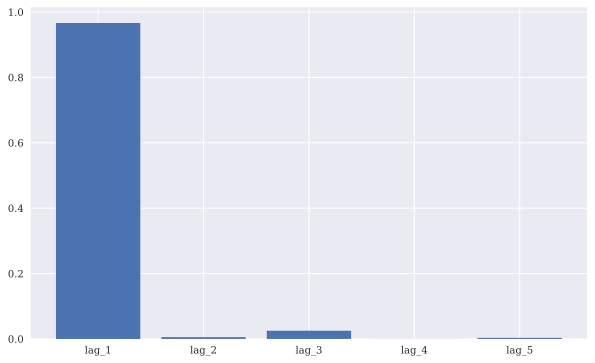

In [62]:
plt.figure(figsize=(10, 6))
plt.bar(cols, x);

We can calculate the prediction y from matrix A and the x vector, that is $y = Ax$ to see whether it is close to the SPX values in other words to estimate the preditive skill of the approach based on the random walk hypothesis.

In [63]:
data['y'] = np.dot(data[cols], reg[0])

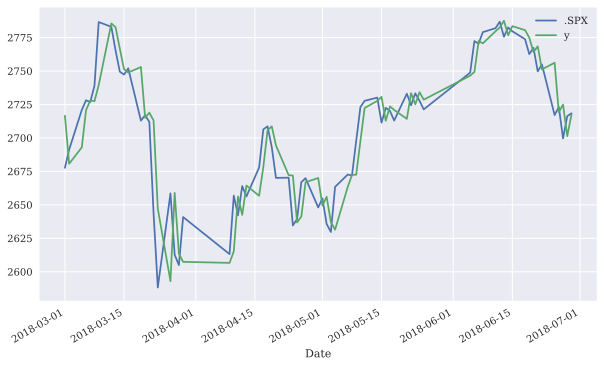

In [65]:
data[[symbol, 'y']].iloc[-75:].plot(figsize=(10, 6));

## Linear regression
Here we define a strategy that is based on the same assumption as before, i.e. the efficient market hypothesis. The difference is that here we use the log return instead of the prices. The log returns are stationary and this is an advantage since one should always use stationary data to perform a statistical analysis. The log-returns are defined as

$$r_i = log(\frac{p_i}{p_{i-1}})$$

if we follow these strategies we buy the asset every time a gain is predict for the next day and we sell every time a loss is predicted.  

In [98]:
raw = pd.read_csv('source/tr_eikon_eod_data.csv', index_col=0, parse_dates=True).dropna()

In [99]:
raw.columns

Index(['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N', 'SPY', '.SPX', '.VIX',
       'EUR=', 'XAU=', 'GDX', 'GLD'],
      dtype='object')

We calculate the returns for one asset

In [100]:
symbol = 'EUR='
data = pd.DataFrame(raw[symbol])
data['returns'] = np.log(data / data.shift(1))
data.dropna(inplace=True)

We compute the direction of the returns, that is whether it was a loss or a gain

In [101]:
data['direction'] = np.sign(data['returns']).astype(int)
data.head()

,EUR=,returns,direction
Date,,,
2010-01-05,1.4368,-0.002988,-1
2010-01-06,1.4412,0.003058,1
2010-01-07,1.4318,-0.006544,-1
2010-01-08,1.4412,0.006544,1
2010-01-11,1.4513,0.006984,1


We plot the histogram of the returns. We can see that it's symmetric around a zero mean value

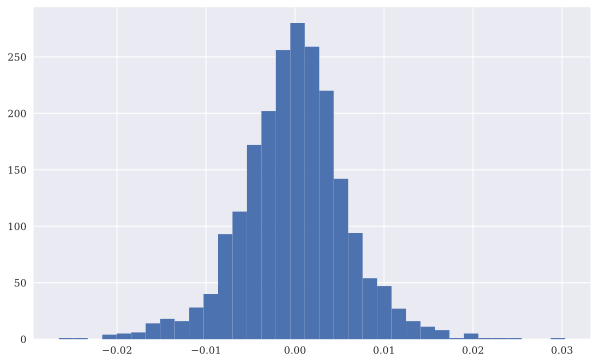

In [77]:
data['returns'].hist(bins=35, figsize=(10, 6));

Following the same approach as before for the prices, we create two lagged time series of returns. Our hope is that according to the random walk hypothesis the lagged data can provide information to predict the next future value of the return

In [102]:
def create_lags(data, lags):
    global cols
    cols = []
    for lag in range(1, lags + 1):
        col = 'lag_{}'.format(lag)
        data[col] = data['returns'].shift(lag)
        cols.append(col)

In [103]:
lags = 2
create_lags(data, lags)

In [104]:
cols

['lag_1', 'lag_2']

In [105]:
data.head()

,EUR=,returns,direction,lag_1,lag_2
Date,,,,,
2010-01-05,1.4368,-0.002988,-1,NaN,NaN
2010-01-06,1.4412,0.003058,1,-0.002988,NaN
2010-01-07,1.4318,-0.006544,-1,0.003058,-0.002988
2010-01-08,1.4412,0.006544,1,-0.006544,0.003058
2010-01-11,1.4513,0.006984,1,0.006544,-0.006544


In [106]:
data.dropna(inplace=True)

From the scatter plot of the two lagged data we can see that there is no relationship even if they come from the same time series.

<Axes: xlabel='lag_1', ylabel='lag_2'>

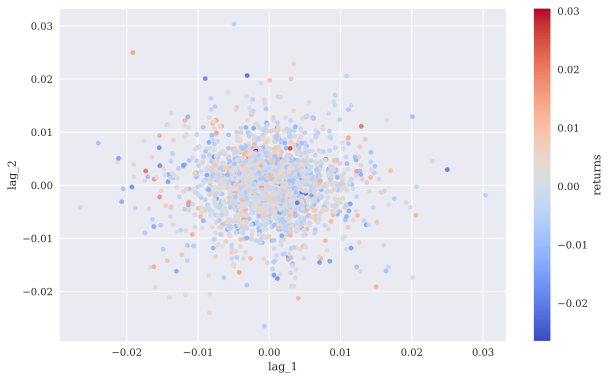

In [83]:
data.plot.scatter(x='lag_1', y='lag_2', c='returns', cmap='coolwarm', figsize=(10, 6), colorbar=True)

We fit two linear models of the type $y = Wx$ where W are the weights to be used to predict the next log returns or the next direction. Whe also make the predictions using the models.  

In [108]:
data.shape

(2135, 7)

In [109]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
data['pos_returns'] = model.fit(data[cols], data['returns']).predict(data[cols])
data['pos_directions'] = model.fit(data[cols], data['direction']).predict(data[cols])
data[['pos_returns', 'pos_directions']].head()

,pos_returns,pos_directions
Date,,
2010-01-07,-0.000166,-0.000086
2010-01-08,0.000017,0.040404
2010-01-11,-0.000244,-0.011756
2010-01-12,-0.000139,-0.043398
2010-01-13,-0.000022,0.002237


We transform the predictions of the log-return into the predictions of the direction

In [111]:
data[['pos_returns', 'pos_directions']] = np.where(data[['pos_returns', 'pos_directions']] > 0, 1, -1)

In [114]:
data['pos_returns'].value_counts()

pos_returns
-1    1847
 1     288
Name: count, dtype: int64

In [115]:
data['pos_directions'].value_counts()

pos_directions
 1    1377
-1     758
Name: count, dtype: int64

In [116]:
(data['pos_returns'].diff() != 0).sum()

555

In [117]:
(data['pos_directions'].diff() != 0).sum()

762

### Vectorized backtest
We can assess the performance of the two strategy based on the random walk assumption by computing the predicted returns, positive and negative of this approach. The result is limited by the fact that we perform the test using the same data as for the training of the model and we do not take into account the transaction costs. With these strategies the transaction costs should not be discarded for the performance assessment since it is assumed that every day a transaction is done (buy or sell). 

In [118]:
data['strat_returns'] = data['pos_returns'] * data['returns']
data['strat_directions'] = data['pos_directions'] * data['returns']

We can see that both strategies outperform the do-nothing strategy with that based on the direction that outperform the one based on the log-returns.

In [119]:
data[['returns', 'strat_returns', 'strat_directions']].sum().apply(np.exp)

returns             0.810644
strat_returns       0.942422
strat_directions    1.339286
dtype: float64

We count the number of times the prediction of the returns was correct

In [123]:
(data['direction'] == data['pos_returns']).value_counts()

False    1093
True     1042
Name: count, dtype: int64

and the number of times the prediction of the directions was correct. We can see that the prediction of the direction was slightely better than that of the return. 

In [124]:
(data['direction'] == data['pos_directions']).value_counts()

True     1096
False    1039
Name: count, dtype: int64

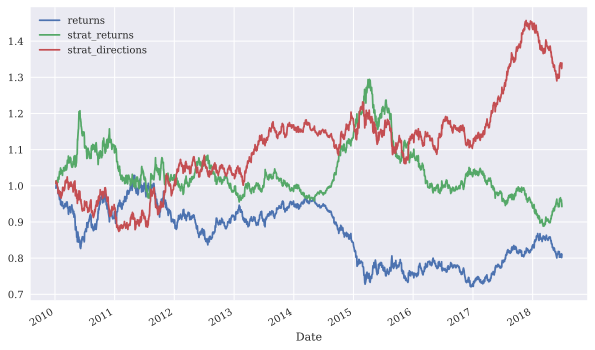

In [125]:
data[['returns', 'strat_returns', 'strat_directions']].cumsum().apply(np.exp).plot(figsize=(10, 6));

## Clustering